# exp051

In [18]:
import os
import sys
import gc
import itertools
import pickle
import pathlib
import datetime
from dateutil.relativedelta import relativedelta
from dotenv import load_dotenv
load_dotenv()
sys.path.append(os.getenv('UTILS_PATH'))

import pandas as pd
import numpy as np
import cudf
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import line_notify

In [19]:
import builtins
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )

In [20]:
SEED = 42
RUN_INF = False # 推論処理を行うか
BATCH_SIZE = int(1e5)
N_ITER = 1 # 学習データのローリング数
RUN_US = True # アンダーサンプリング実施有無
N_SEED = 1 # seed avgの回数

In [21]:
Ns = {}
Ns['cf_a'] = 12
Ns['ctf_a'] = 12
Ns['atfd_a'] = 12
Ns['atfp_a'] = 12
Ns['pa_a'] = 12

Ns['cf_w'] = 12
Ns['ctf_w'] = 12
Ns['atfd_w'] = 12
Ns['atfp_w'] = 12
Ns['pa_w'] = 12

Ns['cf_m'] = 12
Ns['ctf_m'] = 12
Ns['atfd_m'] = 12
Ns['atfp_m'] = 12
Ns['pa_m'] = 12

Ns['cf_y'] = 12
Ns['ctf_y'] = 12
Ns['atfd_y'] = 12
Ns['atfp_y'] = 12
Ns['pa_y'] = 12

ディレクトリ設定

In [22]:
INPUT_DIR = os.getenv('INPUT_DIR')
OUTPUT_DIR = os.getenv('OUTPUT_DIR')
#exp_name = os.path.dirname(__file__).split('/')[-1]
exp_name = 'exp051'
os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

データ読み込み

In [23]:
articles = pd.read_csv(INPUT_DIR + 'articles.csv', dtype='object')
customers = pd.read_csv(INPUT_DIR + 'customers.csv')
transactions = pd.read_csv(INPUT_DIR + 'transactions_train.csv', dtype={'article_id':'str'}, parse_dates=['t_dat'])
sample = pd.read_csv(INPUT_DIR + 'sample_submission.csv')

In [24]:
first_week_sales_pred = pd.read_csv(OUTPUT_DIR + '1st_week_sales_pred_v004/result.csv', dtype={'article_id':'str'},  parse_dates=['1st_week_sales_dat'])

# 前処理

In [25]:
ALL_CUSTOMER = customers['customer_id'].unique().tolist()
ALL_ARTICLE = articles['article_id'].unique().tolist()

customer_ids = dict(list(enumerate(ALL_CUSTOMER)))
article_ids = dict(list(enumerate(ALL_ARTICLE)))

customer_map = {u: uidx for uidx, u in customer_ids.items()}
article_map = {i: iidx for iidx, i in article_ids.items()}

articles['article_id'] = articles['article_id'].map(article_map)
customers['customer_id'] = customers['customer_id'].map(customer_map)
transactions['article_id'] = transactions['article_id'].map(article_map)
transactions['customer_id'] = transactions['customer_id'].map(customer_map)
sample['customer_id'] = sample['customer_id'].map(customer_map)
first_week_sales_pred['article_id'] = first_week_sales_pred['article_id'].map(article_map) 

In [26]:
# 名寄せ
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.replace('None','NONE')

In [27]:
customers['age10'] = str((customers['age'] // 10) * 10)
customers.loc[customers['age'].isnull(), 'age10'] = np.nan

In [28]:
# label_encoding
le_cols = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']
for c in le_cols:
    le = LabelEncoder()
    articles[c] = le.fit_transform(articles[c].fillna(''))


le_cols = ['club_member_status', 'fashion_news_frequency', 'postal_code', 'age10']
for c in le_cols:
    le = LabelEncoder()
    customers[c] = le.fit_transform(customers[c].fillna(''))

In [29]:
customers['customer_type'] = customers['FN'].fillna(0).astype(int).astype(str) + \
                             customers['Active'].fillna(0).astype(int).astype(str) + \
                             customers['club_member_status'].fillna(0).astype(int).astype(str) + \
                             customers['fashion_news_frequency'].fillna(0).astype(int).astype(str) + \
                             customers['age10'].fillna(0).astype(int).astype(str)

le = LabelEncoder()
customers['customer_type'] = le.fit_transform(customers['customer_type'])

In [30]:
# transactionに紐づけ
transactions = transactions.merge(customers, on='customer_id', how='left')
transactions = transactions.merge(articles, on='article_id', how='left')

In [31]:
# text特徴量
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

detail_desc_n_dim = 15
text_col = 'detail_desc'
articles[text_col] = articles[text_col].str.lower()
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
text_tfidf = tfidf_vec.fit_transform(articles[text_col].fillna('').values.tolist())
svd = TruncatedSVD(n_components=detail_desc_n_dim, algorithm='arpack',random_state=42)
text_svd = svd.fit_transform(text_tfidf)
text_svd_df = pd.DataFrame(text_svd, columns=[f'{text_col}_svd_{i}' for i in range(detail_desc_n_dim)])
text_svd_df = pd.concat([articles[['article_id']], text_svd_df], axis=1)

prod_name_n_dim = 15
text_col = 'prod_name'
articles[text_col] = articles[text_col].str.lower()
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
text_tfidf = tfidf_vec.fit_transform(articles[text_col].fillna('').values.tolist())
svd = TruncatedSVD(n_components=prod_name_n_dim, algorithm='arpack',random_state=42)

text_svd = svd.fit_transform(text_tfidf)
text_svd_df_tmp = pd.DataFrame(text_svd, columns=[f'{text_col}_svd_{i}' for i in range(prod_name_n_dim)])
text_svd_df = pd.concat([text_svd_df, text_svd_df_tmp], axis=1)


# データセット作成（レコメンド→対象データセット作成→特徴量エンジニアリング）

In [32]:
@noglobal
def get_customer_frequent(history, n=12, timedelta=None):
    """顧客ごと商品の購入数をカウントし上位の商品を抽出

    Args:
        history (dataframe): 集計対象の実績データ
        n (int): レコメンド対象とする数
        timedelta (dateutil.relativedelta): 指定された場合、実績データの終端からtimedelta分のデータを取得する

    Returns:
        dataframe: 抽出結果
    """
    if timedelta is not None:
        st_date = history['t_dat'].max() - timedelta
        history = history[history['t_dat']>=st_date].copy()
        
    customer_agg = history.groupby(['customer_id', 'article_id'])['t_dat'].count().reset_index()
    customer_agg = customer_agg.rename(columns={'t_dat':'cnt'})
    customer_agg = customer_agg.sort_values(['customer_id', 'cnt'], ascending=False)
    result = customer_agg.groupby('customer_id').head(n)
    return result[['customer_id', 'article_id']]

@noglobal
def get_popular_article(history, n=12, timedelta=None):
    """全体の購入数をカウントし上位の商品を抽出

    Args:
        history (dataframe): 集計対象の実績データ
        n (int): レコメンド対象とする数
        timedelta (dateutil.relativedelta): 指定された場合、実績データの終端からtimedelta分のデータを取得する

    Returns:
        list: 抽出結果
    """
    # 全体の購入数量
    if timedelta is not None:
        st_date = history['t_dat'].max() - timedelta
        history = history[history['t_dat']>=st_date].copy()

    total_agg = history.groupby('article_id')['t_dat'].count().reset_index()
    total_agg = total_agg.rename(columns={'t_dat':'cnt'})
    total_agg = total_agg.sort_values(['cnt'], ascending=False)
    total_agg = total_agg.head(n)
    result = list(total_agg['article_id'].values)
    return result

@noglobal
def get_customer_type_frequent(history, n=12, timedelta=None):
    if timedelta is not None:
        st_date = history['t_dat'].max() - timedelta
        history = history[history['t_dat']>=st_date].copy()

    result = history[['customer_id', 'customer_type']].drop_duplicates().copy()
    agg = history.groupby(['customer_type', 'article_id'])['t_dat'].count().reset_index()
    agg = agg.rename(columns={'t_dat':'cnt'})
    agg = agg.sort_values(['customer_type', 'cnt'], ascending=False)
    agg = agg.groupby('customer_type').head(n)
    result = result.merge(agg[['customer_type', 'article_id']], on='customer_type', how='left')
    return result[['customer_id', 'article_id']]

@noglobal
def get_article_type_frequent(history, col, n=12, timedelta=None):
    if timedelta is not None:
        st_date = history['t_dat'].max() - timedelta
        history = history[history['t_dat']>=st_date].copy()

    result = history.groupby(['customer_id', col])['t_dat'].count().reset_index()
    result = result.rename(columns={'t_dat':'cnt'})
    result = result.sort_values(['customer_id', 'cnt'], ascending=False)
    result = result.groupby(['customer_id']).head(1)[['customer_id', col]]

    agg = history.groupby([col, 'article_id'])['t_dat'].count().reset_index()
    agg = agg.rename(columns={'t_dat':'cnt'})
    agg = agg.sort_values([col, 'cnt'], ascending=False)
    agg = agg.groupby(col).head(n)
    result = result.merge(agg[[col, 'article_id']], on=col, how='left')
    return result[['customer_id', 'article_id']]

@noglobal
def get_popular_new_article(first_week_sales_pred, n=12):
    """新商品の初週売り上げ予測が高い商品を抽出
    """
    first_week_sales_pred = first_week_sales_pred.sort_values(['1st_week_sales_pred'], ascending=False)
    first_week_sales_pred = first_week_sales_pred.head(n)
    result = list(first_week_sales_pred['article_id'].values)
    return result

@noglobal
def calc_pair(history):
    df = history[['article_id', 't_dat', 'customer_id']].copy()
    df = cudf.from_pandas(df)
    df['t_dat'] = df['t_dat'].factorize()[0].astype('int16')
    dt = df.groupby(['customer_id','t_dat'])['article_id'].agg(list).rename('pair').reset_index()
    df = df[['customer_id', 't_dat', 'article_id']].merge(dt, on=['customer_id', 't_dat'], how='left')
    del dt
    gc.collect()

    # Explode the rows vs list of articles
    df = df[['article_id', 'pair']].explode(column='pair')
    gc.collect()
        
    # Discard duplicates
    df = df.loc[df['article_id']!=df['pair']].reset_index(drop=True)
    gc.collect()

    # Count how many times each pair combination happens
    df = df.groupby(['article_id', 'pair']).size().rename('count').reset_index()
    gc.collect()
        
    # Sort by frequency
    df = df.sort_values(['article_id' ,'count'], ascending=False).reset_index(drop=True)
    gc.collect()

    # pick only top1 most frequent pair
    df = df.groupby('article_id').nth(0).reset_index()
    pair = dict(zip(df['article_id'].to_arrow().to_pylist(), df['pair'].to_arrow().to_pylist()))

    return pair

@noglobal
def get_reccomend(target_customer_id, history, Ns, first_week_sales_pred):
    n = 12
    result = pd.DataFrame()
    

    td = None
    result = result.append(get_customer_frequent(history, Ns['cf_a'], td))
    result = result.append(get_customer_type_frequent(history, Ns['ctf_a'], td))
    result = result.append(get_article_type_frequent(history, 'department_name', Ns['atfd_a'], td))
    result = result.append(get_article_type_frequent(history, 'perceived_colour_master_name', Ns['atfp_a'], td))
    popular_article = get_popular_article(history, Ns['pa_a'], td)
    # customerとpopular articleの全組み合わせでdataframe作成
    popular_article = pd.DataFrame(itertools.product(target_customer_id, popular_article), columns=['customer_id', 'article_id'])
    result = result.append(popular_article)

    popular_new_article = get_popular_new_article(first_week_sales_pred, n=48)
    popular_new_article = pd.DataFrame(itertools.product(target_customer_id, popular_new_article), columns=['customer_id', 'article_id'])
    result = result.append(popular_new_article)

    result = result.drop_duplicates()

    td = relativedelta(weeks=1)
    result = result.append(get_customer_frequent(history, Ns['cf_w'], td))
    result = result.append(get_customer_type_frequent(history, Ns['ctf_w'], td))
    result = result.append(get_article_type_frequent(history, 'department_name', Ns['atfd_w'], td))
    result = result.append(get_article_type_frequent(history, 'perceived_colour_master_name', Ns['atfp_w'], td))
    popular_article = get_popular_article(history, Ns['pa_w'], td)
    # customerとpopular articleの全組み合わせでdataframe作成
    popular_article = pd.DataFrame(itertools.product(target_customer_id, popular_article), columns=['customer_id', 'article_id'])
    result = result.append(popular_article)
    result = result.drop_duplicates()

    td = relativedelta(months=1)
    result = result.append(get_customer_frequent(history, Ns['cf_m'], td))
    result = result.append(get_customer_type_frequent(history, Ns['ctf_m'], td))
    result = result.append(get_article_type_frequent(history, 'department_name', Ns['atfd_m'], td))
    result = result.append(get_article_type_frequent(history, 'perceived_colour_master_name', Ns['atfp_m'], td))
    popular_article = get_popular_article(history, Ns['pa_m'], td)
    # customerとpopular articleの全組み合わせでdataframe作成
    popular_article = pd.DataFrame(itertools.product(target_customer_id, popular_article), columns=['customer_id', 'article_id'])
    result = result.append(popular_article)
    result = result.drop_duplicates()

    td = relativedelta(years=1)
    result = result.append(get_customer_frequent(history, Ns['cf_y'], td))
    result = result.append(get_customer_type_frequent(history, Ns['ctf_y'], td))
    result = result.append(get_article_type_frequent(history, 'department_name', Ns['atfd_y'], td))
    result = result.append(get_article_type_frequent(history, 'perceived_colour_master_name', Ns['atfp_y'], td))
    popular_article = get_popular_article(history, Ns['pa_y'], td)
    # customerとpopular articleの全組み合わせでdataframe作成
    popular_article = pd.DataFrame(itertools.product(target_customer_id, popular_article), columns=['customer_id', 'article_id'])
    result = result.append(popular_article)
    result = result.drop_duplicates()

    result = result[result['customer_id'].isin(target_customer_id)].copy()

    purchased_together_pair = calc_pair(history)
    add_result = result.copy()
    add_result['article_id'] = add_result['article_id'].map(purchased_together_pair)
    result = result.append(add_result.dropna().drop_duplicates())
    result = result.drop_duplicates()

    return result

In [33]:
@noglobal
def add_labels(recom_result, history):
    """レコメンドしたデータが学習期間で購入されたかどうかのフラグを付与する

    Args:
        recom_result (_type_): レコメンド結果
        train_tran (_type_): 学習期間のトランザクションデータ

    Returns:
        _type_: 学習期間での購入フラグを付与したレコメンド結果
    """
    history = history[['customer_id', 'article_id']].drop_duplicates()
    history['buy'] = 1
    recom_result = recom_result.merge(history, on=['customer_id', 'article_id'], how='left')
    recom_result['buy'] = recom_result['buy'].fillna(0)
    return recom_result


In [34]:
@noglobal
def make_article_features(articles):
    cols = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']
    return articles[['article_id']+cols]

@noglobal
def make_article_tran_features(history):
    df = history.groupby('article_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'], 
                                            'age':['max', 'min', 'mean', 'std']}).reset_index()
    df.columns = ['article_id','article_total_cnt', 'article_total_latest_buy', 'article_total_1st_buy', 'article_price_max', 'article_price_min', 'article_price_mean', 'article_age_max', 'article_age_min', 'article_age_mean', 'article_age_std']
    df['article_total_1st_buy'] = (history['t_dat'].max() - df['article_total_1st_buy']).dt.days
    df['article_total_latest_buy'] = (history['t_dat'].max() - df['article_total_latest_buy']).dt.days

    history_1weekago = history.loc[(history['t_dat'] > history['t_dat'].max() - relativedelta(days=7)) & 
                                   (history['t_dat'] <= history['t_dat'].max())]

    history_1weekago_df = history_1weekago.groupby('article_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'], 
                                            'age':['max', 'min', 'mean', 'std', 'median']}).reset_index()
    history_1weekago_df.columns = ['article_id','article_total_cnt_1weekago', 'article_total_latest_buy_1weekago', 'article_total_1st_buy_1weekago', 'article_price_max_1weekago', 'article_price_min_1weekago', 'article_price_mean_1weekago', 'article_age_max_1weekago', 'article_age_min_1weekago', 'article_age_mean_1weekago', 'article_age_std_1weekago', 'article_age_median_1weekago']
    history_1weekago_df['article_total_1st_buy_1weekago'] = (history_1weekago['t_dat'].max() - history_1weekago_df['article_total_1st_buy_1weekago']).dt.days
    history_1weekago_df['article_total_latest_buy_1weekago'] = (history_1weekago['t_dat'].max() - history_1weekago_df['article_total_latest_buy_1weekago']).dt.days

    df = pd.merge(df,history_1weekago_df,how='left',on='article_id')

    del history_1weekago, history_1weekago_df
    gc.collect()

    history_2weekago = history.loc[(history['t_dat'] > history['t_dat'].max() - relativedelta(days=14)) & 
                                   (history['t_dat'] <= history['t_dat'].max() - relativedelta(days=7))]

    history_2weekago_df = history_2weekago.groupby('article_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'], 
                                            'age':['max', 'min', 'mean', 'std', 'median']}).reset_index()
    history_2weekago_df.columns = ['article_id','article_total_cnt_2weekago', 'article_total_latest_buy_2weekago', 'article_total_1st_buy_2weekago', 'article_price_max_2weekago', 'article_price_min_2weekago', 'article_price_mean_2weekago', 'article_age_max_2weekago', 'article_age_min_2weekago', 'article_age_mean_2weekago', 'article_age_std_2weekago', 'article_age_median_2weekago']
    history_2weekago_df['article_total_1st_buy_2weekago'] = (history_2weekago['t_dat'].max() - history_2weekago_df['article_total_1st_buy_2weekago']).dt.days
    history_2weekago_df['article_total_latest_buy_2weekago'] = (history_2weekago['t_dat'].max() - history_2weekago_df['article_total_latest_buy_2weekago']).dt.days

    df = pd.merge(df,history_2weekago_df,how='left',on='article_id')

    del history_2weekago, history_2weekago_df
    gc.collect()
    """
    online_df = history[history['sales_channel_id'] == 2].copy()
    online_df = online_df.groupby('article_id').agg({'t_dat':['count', 'max', 'min'],
                                                     'price':['max', 'min', 'mean'], 
                                                     'age':['max', 'min', 'mean', 'std']}).reset_index()
    online_df.columns = ['article_id','online_article_total_cnt', 'online_article_total_latest_buy', 'online_article_total_1st_buy', 'online_article_price_max', 'online_article_price_min', 'online_article_price_mean', 'online_article_age_max', 'online_article_age_min', 'online_article_age_mean', 'online_article_age_std']
    online_df['online_article_total_1st_buy'] = (history['t_dat'].max() - online_df['online_article_total_1st_buy']).dt.days
    online_df['online_article_total_latest_buy'] = (history['t_dat'].max() - online_df['online_article_total_latest_buy']).dt.days
    df = pd.merge(df,online_df, how='left', on='article_id')
    del online_df
    gc.collect()

    shop_df = history[history['sales_channel_id'] == 1].copy()
    shop_df = shop_df.groupby('article_id').agg({'t_dat':['count', 'max', 'min'],
                                                 'price':['max', 'min', 'mean'], 
                                                 'age':['max', 'min', 'mean', 'std']}).reset_index()
    shop_df.columns = ['article_id','shop_article_total_cnt', 'shop_article_total_latest_buy', 'shop_article_total_1st_buy', 'shop_article_price_max', 'shop_article_price_min', 'shop_article_price_mean', 'shop_article_age_max', 'shop_article_age_min', 'shop_article_age_mean', 'shop_article_age_std']
    shop_df['shop_article_total_1st_buy'] = (history['t_dat'].max() - shop_df['shop_article_total_1st_buy']).dt.days
    shop_df['shop_article_total_latest_buy'] = (history['t_dat'].max() - shop_df['shop_article_total_latest_buy']).dt.days
    df = pd.merge(df, shop_df, how='left', on='article_id')
    del shop_df
    gc.collect()    
    """

    return df


@noglobal
def make_customer_features(customers):
    return customers

@noglobal
def make_customer_tran_features(history):
    group = ['Ladieswear', 'Divided', 'Menswear', 'Sport', 'Baby/Children']
    for g in group:
        history[g] = 0
        history.loc[history['index_group_name']==g, g] = 1


    df = history.groupby('customer_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'],
                                            'Ladieswear':'sum',
                                            'Divided':'sum',
                                            'Menswear':'sum',
                                            'Sport':'sum',
                                            'Baby/Children':'sum'}).reset_index()
    df.columns = ['customer_id','customer_total_cnt', 'customer_total_latest_buy', 'customer_total_1st_buy', 
                  'customer_price_max', 'customer_price_min', 'customer_price_mean',
                  'Ladieswear', 'Divided', 'Menswear', 'Sport', 'Baby/Children']
    df['customer_total_1st_buy'] = (history['t_dat'].max() - df['customer_total_1st_buy']).dt.days
    df['customer_total_latest_buy'] = (history['t_dat'].max() - df['customer_total_latest_buy']).dt.days

    for g in group:
        df[g] = df[g] / df['customer_total_cnt']

#####################iida_exp24#########################
    history_1weekago = history.loc[(history['t_dat'] > history['t_dat'].max() - relativedelta(days=7)) & 
                                   (history['t_dat'] <= history['t_dat'].max())]
    history_1weekago_df =  history_1weekago.groupby('customer_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'],
                                            'Ladieswear':'sum',
                                            'Divided':'sum',
                                            'Menswear':'sum',
                                            'Sport':'sum',
                                            'Baby/Children':'sum'}).reset_index() 
    history_1weekago_df.columns = ['customer_id','customer_total_cnt_1weekago', 'customer_total_latest_buy_1weekago', 'customer_total_1st_buy_1weekago', 
                                'customer_price_max_1weekago', 'customer_price_min_1weekago', 'customer_price_mean_1weekago',
                                'Ladieswear_1weekago', 'Divided_1weekago', 'Menswear_1weekago', 'Sport_1weekago', 'Baby/Children_1weekago']

    history_1weekago_df['customer_total_1st_buy_1weekago'] = (history_1weekago['t_dat'].max() - history_1weekago_df['customer_total_1st_buy_1weekago']).dt.days
    history_1weekago_df['customer_total_latest_buy_1weekago'] = (history_1weekago['t_dat'].max() - history_1weekago_df['customer_total_latest_buy_1weekago']).dt.days

    for g in group:
        history_1weekago_df[g+'_1weekago'] = history_1weekago_df[g+'_1weekago'] / history_1weekago_df['customer_total_cnt_1weekago']

    df = pd.merge(df,history_1weekago_df,how='left',on='customer_id')

    history_2weekago = history.loc[(history['t_dat'] > history['t_dat'].max() - relativedelta(days=14)) & 
                                   (history['t_dat'] <= history['t_dat'].max() - relativedelta(days=7))]
    history_2weekago_df =  history_2weekago.groupby('customer_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'],
                                            'Ladieswear':'sum',
                                            'Divided':'sum',
                                            'Menswear':'sum',
                                            'Sport':'sum',
                                            'Baby/Children':'sum'}).reset_index() 
    history_2weekago_df.columns = ['customer_id','customer_total_cnt_2weekago', 'customer_total_latest_buy_2weekago', 'customer_total_1st_buy_2weekago', 
                                'customer_price_max_2weekago', 'customer_price_min_2weekago', 'customer_price_mean_2weekago',
                                'Ladieswear_2weekago', 'Divided_2weekago', 'Menswear_2weekago', 'Sport_2weekago', 'Baby/Children_2weekago']

    history_2weekago_df['customer_total_1st_buy_2weekago'] = (history_2weekago['t_dat'].max() - history_2weekago_df['customer_total_1st_buy_2weekago']).dt.days
    history_2weekago_df['customer_total_latest_buy_2weekago'] = (history_2weekago['t_dat'].max() - history_2weekago_df['customer_total_latest_buy_2weekago']).dt.days

    for g in group:
        history_2weekago_df[g+'_2weekago'] = history_2weekago_df[g+'_2weekago'] / history_2weekago_df['customer_total_cnt_2weekago']

    df = pd.merge(df,history_2weekago_df,how='left',on='customer_id')

    del history_2weekago, history_2weekago_df
    gc.collect()

    return df

@noglobal
def make_customer_article_features(target, history):
    df = target.merge(history, on=['customer_id', 'article_id'], how='inner')
    df = df.groupby(['customer_id', 'article_id']).agg({'t_dat':['count', 'min', 'max']}).reset_index()
    df.columns = ['customer_id', 'article_id', 'count', '1st_buy_date_diff', 'latest_buy_date_diff']
    df['1st_buy_date_diff'] = (history['t_dat'].max() - df['1st_buy_date_diff']).dt.days
    df['latest_buy_date_diff'] = (history['t_dat'].max() - df['latest_buy_date_diff']).dt.days
    return df

@noglobal
def add_same_article_type_rate(target, history, col):
    add_data = history[['customer_id', col]].copy()
    add_data['total'] = add_data.groupby('customer_id').transform('count')
    add_data = add_data.groupby(['customer_id', col])['total'].agg(['max', 'count']).reset_index()
    add_data[f'{col}_customer_buy_rate'] = add_data['count'] / add_data['max']
    target = target.merge(add_data[['customer_id', col, f'{col}_customer_buy_rate']], on=['customer_id', col], how='left')
    return target

@noglobal
def make_new_article_features(first_week_sales_pred):
    first_week_sales_pred['new_article'] = 1
    return first_week_sales_pred[['article_id', 'new_article', '1st_week_sales_pred']]
    

@noglobal
def add_features(df, history, articles, customers, first_week_sales_pred, text_svd_df):
    df = df.merge(make_article_features(articles), on=['article_id'], how='left')
    df = df.merge(make_article_tran_features(history), on=['article_id'], how='left')
    df = df.merge(make_customer_features(customers), on=['customer_id'], how='left')
    df = df.merge(make_customer_tran_features(history), on=['customer_id'], how='left')
    df = df.merge(make_customer_article_features(df[['customer_id', 'article_id']], history), on=['article_id', 'customer_id'], how='left')
    df = df.merge(make_new_article_features(first_week_sales_pred), on=['article_id'], how='left')
    df = df.merge(text_svd_df, on=['article_id'], how='left')

    cols = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']

    for c in cols:
        df = add_same_article_type_rate(df, history, c)

    return df
    

# レコメンド商品を購入するかどうかの2値分類モデル

In [35]:
def apk(y_true, y_pred, K=12):
    assert(len(y_true) == len(y_pred))
    apks = []
    for idx in range(len(y_true)):
        y_i_true = y_true[idx]
        y_i_pred = y_pred[idx]

        # 予測値の数と重複の確認
        assert(len(y_i_pred) <= K)
        assert(len(np.unique(y_i_pred)) == len(y_i_pred))

        sum_precision = 0.0
        num_hits = 0.0

        for i, p in enumerate(y_i_pred):
            if p in y_i_true:
                num_hits += 1
                precision = num_hits / (i+1)
                sum_precision += precision
        apk = sum_precision / min(len(y_i_true), K)
        apks.append(apk)
    return apks

In [36]:
# 学習データの作成
# 1週ずつローリングして学習データを生成
train_start = '2020-09-09'
valid_start = '2020-09-16'
valid_end = '2020-09-22'

hist_st = train_start
target_st = valid_start
ml_train = pd.DataFrame()

for i in range(N_ITER):
    print(i)
    history_tran = transactions[transactions['t_dat'] < hist_st].copy()
    target_tran = transactions[(transactions['t_dat'] >= hist_st) & (transactions['t_dat'] < target_st)].copy()
    first_week_sales_pred_tmp = first_week_sales_pred[(first_week_sales_pred['1st_week_sales_dat'] >= target_tran['t_dat'].min())&(first_week_sales_pred['1st_week_sales_dat'] <= target_tran['t_dat'].max())]

    target_id = target_tran['customer_id'].unique().tolist()
    recom = get_reccomend(target_id, history_tran, Ns, first_week_sales_pred_tmp)
    ml_train_tmp = add_labels(recom, target_tran)

    # under sampling
    if RUN_US:
        sample_n = int(ml_train_tmp['buy'].sum())
        ml_train_tmp0 = ml_train_tmp[ml_train_tmp['buy']==0.0].sample(sample_n, random_state=SEED)
        ml_train_tmp1 = ml_train_tmp[ml_train_tmp['buy']==1.0].copy()
        ml_train_tmp = pd.concat([ml_train_tmp0, ml_train_tmp1])

    ml_train_tmp = add_features(ml_train_tmp, history_tran, articles, customers, first_week_sales_pred_tmp, text_svd_df)

    ml_train = ml_train.append(ml_train_tmp)

    hist_st = history_tran['t_dat'].max() - relativedelta(days=7)
    target_st = target_tran['t_dat'].max() - relativedelta(days=7)

ml_train = ml_train.reset_index(drop=True)
# ml_train.to_csv(OUTPUT_DIR + f'{exp_name}/ml_train.csv', index=False)

0


/opt/conda/lib/python3.8/site-packages/cudf/core/series.py:923: FutureWarning: Series.set_index is deprecated and will be removed in the future
  warnings.warn(
/tmp/ipykernel_26923/1017582468.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week_sales_pred['new_article'] = 1


In [37]:
# 評価データの作成
history_tran = transactions[transactions['t_dat'] < valid_start].copy()
target_tran = transactions[transactions['t_dat'] >= valid_start].copy()
first_week_sales_pred_tmp = first_week_sales_pred[(first_week_sales_pred['1st_week_sales_dat'] >= target_tran['t_dat'].min())&(first_week_sales_pred['1st_week_sales_dat'] <= target_tran['t_dat'].max())]

target_id = target_tran['customer_id'].unique().tolist()
recom = get_reccomend(target_id, history_tran, Ns, first_week_sales_pred_tmp)
ml_valid = add_labels(recom, target_tran)
ml_valid = add_features(ml_valid, history_tran, articles, customers, first_week_sales_pred_tmp, text_svd_df)
#ml_valid.to_csv(OUTPUT_DIR + f'{exp_name}/ml_valid.csv', index=False)

In [38]:
params = {
 'objective': 'binary',
 'boosting': 'gbdt',
 'learning_rate': 0.01,
 'metric': 'binary_logloss',
 'seed': 42,
 'feature_pre_filter': False,
 'lambda_l1': 2.652545580792273e-07,
 'lambda_l2': 4.127044972448657e-07,
 'num_leaves': 100,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.7235734670479185,
 'bagging_freq': 1,
 'min_child_samples': 100
}

In [39]:
# model生成
target = 'buy'
not_use_cols = ['customer_id', 'article_id', target]
features = [c for c in ml_train.columns if c not in not_use_cols]
fi = pd.DataFrame()
vl_pred = np.zeros(len(ml_valid))
scores = []
# 学習
tr_x, tr_y = ml_train[features], ml_train[target]
vl_x, vl_y = ml_valid[features], ml_valid[target]
tr_data = lgb.Dataset(tr_x, label=tr_y)
vl_data = lgb.Dataset(vl_x, label=vl_y)

# 正解データ作成
valid = transactions[(transactions['t_dat'] >= valid_start) & (transactions['t_dat'] <= valid_end)].copy()
valid = valid[['customer_id', 'article_id']].drop_duplicates()
valid = valid.groupby('customer_id')['article_id'].apply(list).reset_index()
valid = valid.sort_values('customer_id').reset_index(drop=True)

for i in range(N_SEED):
    params['seed'] = i

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                    num_boost_round=20000, early_stopping_rounds=100,verbose_eval=1000)

    # 特徴量重要度
    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.feature_name()
    fi_tmp['importance'] = model.feature_importance(importance_type='gain')
    fi_tmp['iter'] = i
    fi = fi.append(fi_tmp)

    # cv
    vl_pred += model.predict(vl_x, num_iteration=model.best_iteration)

    # 2値分類の出力を元に12個選定
    valid_pred = ml_valid[['customer_id', 'article_id']].copy()
    valid_pred['prob'] = vl_pred
    valid_pred = valid_pred.sort_values(['customer_id', 'prob'], ascending=False)
    valid_pred = valid_pred.groupby('customer_id').head(12)
    valid_pred = valid_pred.groupby('customer_id')['article_id'].apply(list).reset_index()
    valid_pred = valid_pred.sort_values('customer_id').reset_index(drop=True)
    assert(valid['customer_id'].tolist() == valid_pred['customer_id'].tolist())
    # MAP@12
    score = np.mean(apk(valid['article_id'].tolist(), valid_pred['article_id'].tolist()))
    scores.append(score)

    print(i, score)

    #with open(OUTPUT_DIR + f'{exp_name}/model{i}.pickle', 'wb') as f:
    #    pickle.dump(model, f)

ml_valid['pred'] = vl_pred
#ml_valid.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_oof.csv', index=False)

print(f'MAP@12 : ' + '{:.5f}'.format(score))

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 21998, number of negative: 21998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19805
[LightGBM] [Info] Number of data points in the train set: 43996, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[812]	training's binary_logloss: 0.313927	valid_1's binary_logloss: 0.443621
0 0.031236331565952194
MAP@12 : 0.03124


In [40]:
scores

[0.031236331565952194]

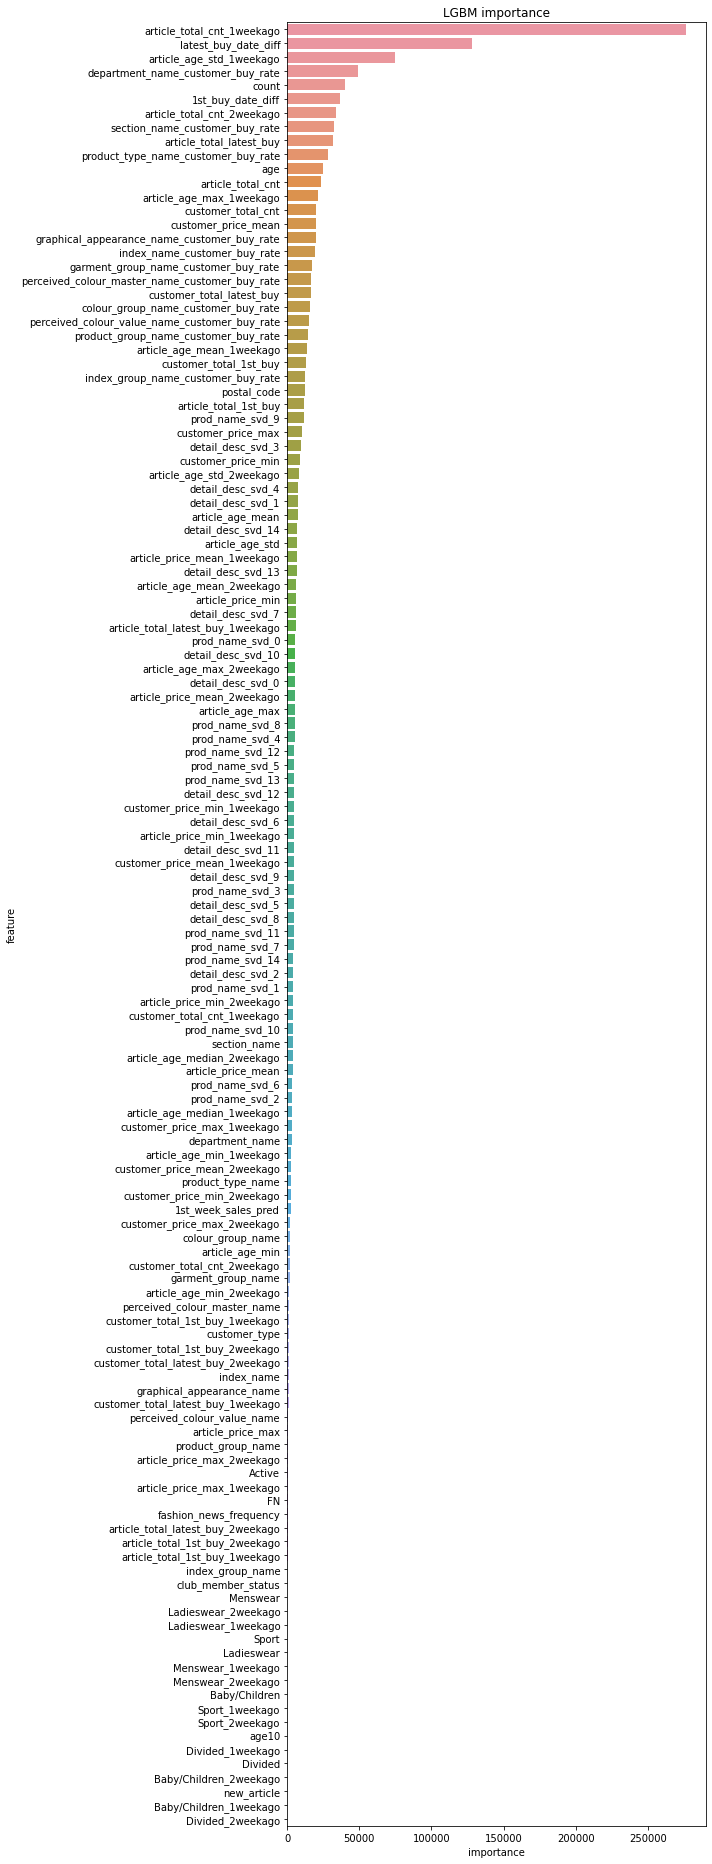

In [41]:
fi_n = fi['feature'].nunique()
order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, fi_n*0.2))
sns.barplot(x="importance", y="feature", data=fi, order=order)
plt.title(f"LGBM importance")
plt.tight_layout()
plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

In [42]:
del history_tran, target_tran, target_id, recom
del ml_train, ml_valid, tr_x, tr_y, vl_x, vl_y, tr_data, vl_data, valid, valid_pred
gc.collect()

28998

# sub

In [43]:
if RUN_INF:
    # テストデータの作成
    all_target_id = sample['customer_id'].tolist()
    first_week_sales_pred_tmp = first_week_sales_pred[first_week_sales_pred['1st_week_sales_dat'] >= '2020/09/23']

    # メモリのケアのためバッチで推論を回す
    batchs = [all_target_id[i:i+BATCH_SIZE] for i in range(0, len(all_target_id), BATCH_SIZE)]
    
    preds = []
    
    for target_id in batchs:
        recom = get_reccomend(target_id, transactions, Ns, first_week_sales_pred_tmp)
        ml_test = add_features(recom, transactions, articles, customers, first_week_sales_pred_tmp, text_svd_df)

        test_pred = np.zeros(len(ml_test))
        models = pathlib.Path(OUTPUT_DIR + f'{exp_name}').glob('model*.pickle')

        for m in models:
            with open(m, 'rb') as f:
                model = pickle.load(f)
        test_pred += model.predict(ml_test[features], num_iteration=model.best_iteration) / N_SEED

        test = ml_test[['customer_id', 'article_id']].copy()
        test['prob'] = test_pred
        test = test.sort_values(['customer_id', 'prob'], ascending=False)
        test = test.groupby('customer_id').head(12)
        preds.append(test)
    
    del recom, ml_test, test_pred
    gc.collect()

    test = pd.concat(preds)
    test['article_id'] = test['article_id'].map(article_ids)
    test['customer_id'] = test['customer_id'].map(customer_ids)

    test = test.groupby('customer_id')['article_id'].apply(list).reset_index()

    sub = sample['customer_id'].map(customer_ids).to_frame()
    sub = sub.merge(test, on=['customer_id'], how='left')
    sub = sub.rename(columns={'article_id':'prediction'})
    assert(sub['prediction'].apply(len).min()==12)
    sub['prediction'] = sub['prediction'].apply(lambda x: ' '.join(x))
    sub.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_sub.csv', index=False)
    

In [44]:
message = f'{exp_name} is finished!\nvalid_score : {score}'
line_notify.send(message)